In [1]:
#Import the required libraries
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

In [2]:
#Load dataset
df = pd.read_csv('Datasets/Password_Strength_Dataset.csv') 

#Data cleaning
df_dropna = df.dropna()  

def strength_to_numeric(strength):
  if strength == 'Weak':
    return 0
  elif strength == 'Medium':
    return 1
  elif strength == 'Strong':
    return 2



In [3]:
#Password Strength Encoding
df['num_strength'] = df['Strength'].apply(strength_to_numeric)

#Shuffle dataset for randomness and robustness
data = df.sample(frac=1, random_state=42).reset_index(drop=True)


In [4]:
#Feature Extraction
def password_length(password):
    return len(password)

def count_digits(password):
    return sum(char.isdigit() for char in password)

def count_uppercase(password):
    return sum(char.isupper() for char in password)

def count_special_characters(password):
    return sum(not char.isalnum() for char in password)

data['length'] = data['Password'].apply(password_length)
data['digits'] = data['Password'].apply(count_digits)
data['uppercase'] = data['Password'].apply(count_uppercase)
data['special_chars'] = data['Password'].apply(count_special_characters)

In [5]:
#Check the unique lengths of passwords
print(data['length'].unique())

[ 8 11 16 10  9  4 13 15  3  5  7 14 12  6]


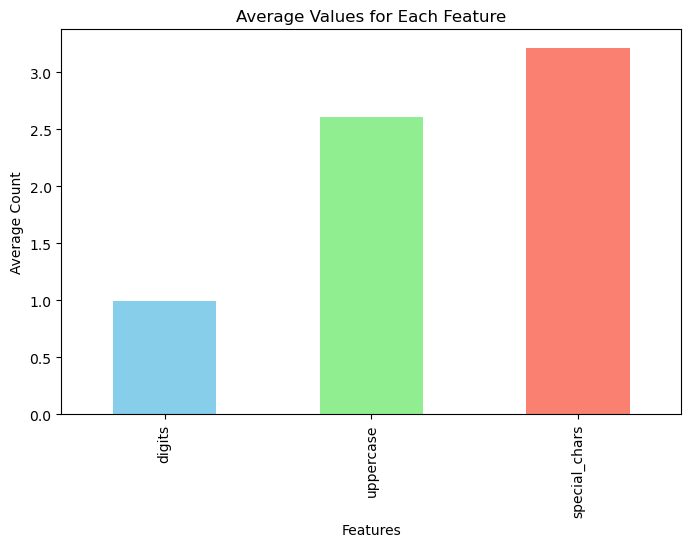

In [6]:
# Create a DataFrame
df = pd.DataFrame(data)

# Calculate the average (mean) for each feature column
avg_values = df[['digits', 'uppercase', 'special_chars']].mean()

# Plot a bar graph for the average values
plt.figure(figsize=(8, 5))
avg_values.plot(kind='bar', color=['skyblue', 'lightgreen', 'salmon'])

# Adding titles and labels
plt.title('Average Values for Each Feature')
plt.xlabel('Features')
plt.ylabel('Average Count')

# Show the plot
plt.show()

In [7]:
# Group the data by the 'length' column
grouped = data.groupby('length')

group_counts = grouped.size()

#print("Counts of each group:")
#print(group_counts)

# Print the highest count
highest_count = group_counts.max()
highest_length = group_counts.idxmax()
print(f"Highest count: {highest_count} for length {highest_length}")

# Print the lowest count
lowest_count = group_counts.min()
lowest_length = group_counts.idxmin()
print(f"Lowest count: {lowest_count} for length {lowest_length}")

#Verify the count for specific length
specific_length = 7 

# Print the size for the specific length
specific_length_count = group_counts.get(specific_length, 0)
print(f"Count for length {specific_length}: {specific_length_count}")

Highest count: 748 for length 8
Lowest count: 679 for length 16
Count for length 7: 710


In [8]:

#Check the labels for all the lengths
#for length, group in grouped:
#    unique_strengths = group['num_strength'].unique()
#    print(f"Unique values for length {length}: {unique_strengths}")


In [9]:
# Choose a specific group to run the code on
selected_length = 15
selected_group = grouped.get_group(selected_length)

In [10]:
# Initialize TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the passwords
X_password = vectorizer.fit_transform(selected_group['Password'])
X_additional = selected_group[[ 'digits', 'uppercase', 'special_chars']].values
X = hstack([X_password, X_additional])

# Encode the labels
y = selected_group['num_strength']

In [11]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Resample data
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

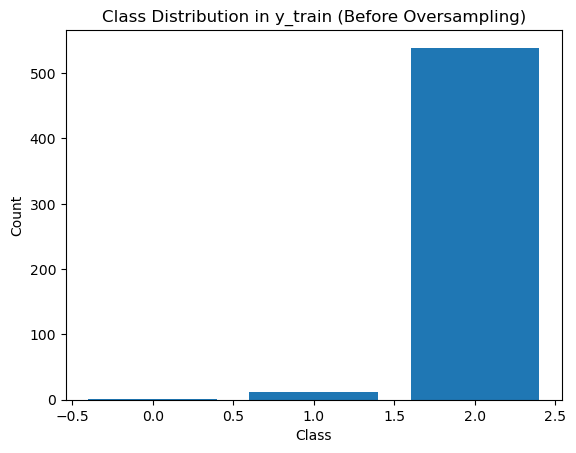

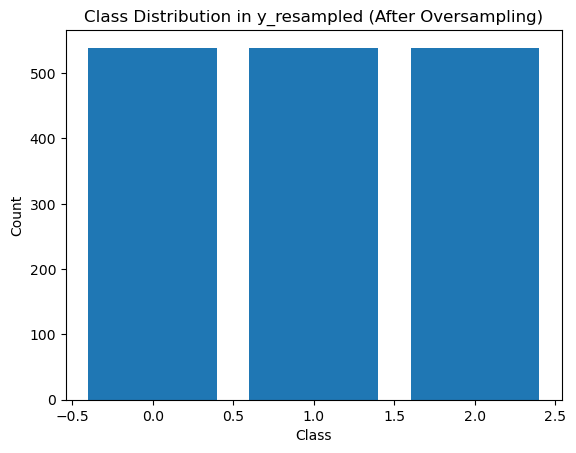

In [12]:
# Plot class distribution
def plot_class_distribution(y, title):
    class_counts = pd.Series(y).value_counts()
    plt.bar(class_counts.index, class_counts.values)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title(title)
    plt.show()

plot_class_distribution(y_train, 'Class Distribution in y_train (Before Oversampling)')
plot_class_distribution(y_resampled, 'Class Distribution in y_resampled (After Oversampling)')


In [13]:
# Function to train the model 
def train_model(model, X_train, y_train):
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    training_time = end_time - start_time
    return model, training_time

In [14]:
# Function to evaluate the model on both training and testing data
def evaluate_model(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate the evaluation metrics for both training and testing data
    metrics = {
        'Train Accuracy': accuracy_score(y_train, y_train_pred),
        'Test Accuracy': accuracy_score(y_test, y_test_pred),
        'Train Precision': precision_score(y_train, y_train_pred, average='weighted', zero_division=0),
        'Test Precision': precision_score(y_test, y_test_pred, average='weighted', zero_division=0),
        'Train Recall': recall_score(y_train, y_train_pred, average='weighted'),
        'Test Recall': recall_score(y_test, y_test_pred, average='weighted'),
        'Train F1 Score': f1_score(y_train, y_train_pred, average='weighted'),
        'Test F1 Score': f1_score(y_test, y_test_pred, average='weighted')
    }
    
    classification_rep = classification_report(y_test, y_test_pred, zero_division=0)
    
    return metrics, classification_rep

In [15]:
# Function to print the metrics 
def print_metrics(model_name, metrics, classification_rep, training_time):
    print(f"\n{model_name} Training Time: {training_time:.2f} seconds")
    print(f"{model_name} Training Accuracy: {metrics['Train Accuracy']:.3f}")
    print(f"{model_name} Test Accuracy: {metrics['Test Accuracy']:.3f}")
    print(f"{model_name} Training Precision: {metrics['Train Precision']:.3f}")
    print(f"{model_name} Test Precision: {metrics['Test Precision']:.3f}")
    print(f"{model_name} Training Recall: {metrics['Train Recall']:.3f}")
    print(f"{model_name} Test Recall: {metrics['Test Recall']:.3f}")
    print(f"{model_name} Training F1 Score: {metrics['Train F1 Score']:.3f}")
    print(f"{model_name} Test F1 Score: {metrics['Test F1 Score']:.3f}")
    print("\nClassification Report on Test Data:")
    print(classification_rep)

In [16]:
# Function to plot the learning curve of the model
def plot_learning_curve(model, X, y, model_name):
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Get learning curve data
    train_sizes, train_scores, validation_scores = learning_curve(
        model, X, y, cv=kfold, n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 10), 
        scoring='accuracy'
    )
    
    # Calculate mean and standard deviation for training and validation scores
    train_mean = np.mean(train_scores, axis=1)
    validation_mean = np.mean(validation_scores, axis=1)
    
    # Plot learning curve
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
    plt.plot(train_sizes, validation_mean, 'o-', color='green', label='Validation score')
    
    plt.fill_between(train_sizes, train_mean - np.std(train_scores, axis=1), 
                     train_mean + np.std(train_scores, axis=1), alpha=0.1, color='blue')
    plt.fill_between(train_sizes, validation_mean - np.std(validation_scores, axis=1), 
                     validation_mean + np.std(validation_scores, axis=1), alpha=0.1, color='green')
    
    plt.title(f'Learning Curve ({model_name})')
    plt.xlabel('Training examples')
    plt.ylabel('Accuracy Score')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
    # Determine the point of convergence
    convergence_point = np.argmax(validation_mean)
    convergence_score = validation_mean[convergence_point]
    
    print(f"\n{model_name} converges at {train_sizes[convergence_point]} training examples with a validation score of {convergence_score:.3f}")
    
    return train_sizes[convergence_point], convergence_score

In [17]:
#Function to Plot metrics
def plot_metrics(metrics):
    labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    
    train_metrics = {
        'Logistic Regression': [metrics['Logistic Regression']['Train Accuracy'], 
                                metrics['Logistic Regression']['Train Precision'], 
                                metrics['Logistic Regression']['Train Recall'], 
                                metrics['Logistic Regression']['Train F1 Score']],
        'Decision Tree': [metrics['Decision Tree']['Train Accuracy'], 
                          metrics['Decision Tree']['Train Precision'], 
                          metrics['Decision Tree']['Train Recall'], 
                          metrics['Decision Tree']['Train F1 Score']],
        'Random Forest': [metrics['Random Forest']['Train Accuracy'], 
                          metrics['Random Forest']['Train Precision'], 
                          metrics['Random Forest']['Train Recall'], 
                          metrics['Random Forest']['Train F1 Score']]
    }
    
    test_metrics = {
        'Logistic Regression': [metrics['Logistic Regression']['Test Accuracy'], 
                                metrics['Logistic Regression']['Test Precision'], 
                                metrics['Logistic Regression']['Test Recall'], 
                                metrics['Logistic Regression']['Test F1 Score']],
        'Decision Tree': [metrics['Decision Tree']['Test Accuracy'], 
                          metrics['Decision Tree']['Test Precision'], 
                          metrics['Decision Tree']['Test Recall'], 
                          metrics['Decision Tree']['Test F1 Score']],
        'Random Forest': [metrics['Random Forest']['Test Accuracy'], 
                          metrics['Random Forest']['Test Precision'], 
                          metrics['Random Forest']['Test Recall'], 
                          metrics['Random Forest']['Test F1 Score']]
    }

    x = np.arange(len(labels))  # the label locations
    width = 0.25  # the width of the bars

    fig, ax = plt.subplots(2, 1, figsize=(14, 13))
    colors = ['lightblue', 'lightgreen', 'salmon']

    # Plot training metrics
    for i, (label, values) in enumerate(train_metrics.items()):
        bars = ax[0].bar(x + i * width, values, width, label=label, color=colors[i])
        autolabel(bars, ax[0])

    ax[0].set_xlabel('Metrics')
    ax[0].set_ylabel('Scores')
    ax[0].set_title('Comparison of Training Metrics Across Models')
    ax[0].set_xticks(x + width)
    ax[0].set_xticklabels(labels)
    ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
    ax[0].set_ylim(0, 1.1)

    # Plot testing metrics
    for i, (label, values) in enumerate(test_metrics.items()):
        bars = ax[1].bar(x + i * width, values, width, label=label, color=colors[i])
        autolabel(bars, ax[1])

    ax[1].set_xlabel('Metrics')
    ax[1].set_ylabel('Scores')
    ax[1].set_title('Comparison of Testing Metrics Across Models')
    ax[1].set_xticks(x + width)
    ax[1].set_xticklabels(labels)
    ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
    ax[1].set_ylim(0, 1.1)

    fig.tight_layout()
    plt.show()

def autolabel(bars, ax):
    """Attach a text label above each bar in *bars*, displaying its height."""
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')




In [30]:
def plot_computational_time(training_times):
    models = list(training_times.keys())
    times = list(training_times.values())
    
    plt.figure(figsize=(8, 5))
    
    # Plot the computational time as a line graph
    plt.plot(models, times, marker='o', color='salmon', linestyle='-', linewidth=2, markersize=8)
    
    # Add labels and title
    plt.title('Computational Time of Different Models')
    plt.xlabel('Model')
    plt.ylabel('Training Time (seconds)')
    
    # Annotate each marker with its exact value
    for model, time in zip(models, times):
        plt.annotate(f'{time:.2f}',  # Format the time to two decimal places
                     (model, time),  # Position of the annotation
                     textcoords="offset points",  # Coordinate system for the offset
                     xytext=(0, 5),  # Move the text closer to the marker (5 points above)
                     ha='center',  # Center the text horizontally
                     fontsize=9,  # Font size of the annotation
                     color='black')  # Color of the annotation text
    
    # Show the plot with grid
    plt.grid(True)
    plt.show()

In [19]:
#Initialize the ML models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42)
}

model_metrics = {}
convergence_points = {}

In [20]:
# Train the Logistic Regression model
print("Training Logistic Regression...")
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
trained_logistic_model, logistic_training_time = train_model(logistic_model, X_train, y_train)
logistic_metrics, logistic_classification_rep = evaluate_model(trained_logistic_model, X_train, y_train, X_test, y_test)
model_metrics['Logistic Regression'] = logistic_metrics
print_metrics('Logistic Regression', logistic_metrics, logistic_classification_rep, logistic_training_time)


Training Logistic Regression...

Logistic Regression Training Time: 0.56 seconds
Logistic Regression Training Accuracy: 0.976
Logistic Regression Test Accuracy: 0.986
Logistic Regression Training Precision: 0.953
Logistic Regression Test Precision: 0.971
Logistic Regression Training Recall: 0.976
Logistic Regression Test Recall: 0.986
Logistic Regression Training F1 Score: 0.965
Logistic Regression Test F1 Score: 0.978

Classification Report on Test Data:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           2       0.99      1.00      0.99       136

    accuracy                           0.99       138
   macro avg       0.49      0.50      0.50       138
weighted avg       0.97      0.99      0.98       138



Plotting learning curve for Logistic Regression...


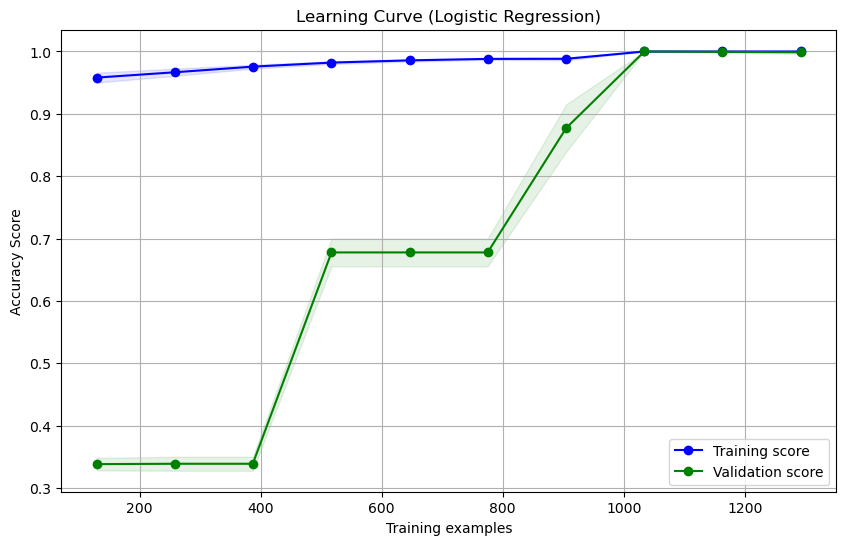


Logistic Regression converges at 1034 training examples with a validation score of 1.000


In [21]:
#Plot the learning curve for Logistic Regression
print("Plotting learning curve for Logistic Regression...")
logistic_point, logistic_score = plot_learning_curve(trained_logistic_model, X_resampled, y_resampled, 'Logistic Regression')
convergence_points['Logistic Regression'] = (logistic_point, logistic_score)


In [22]:
# Train the Decision Tree model 
print("Training Decision Tree...")
decision_tree_model = DecisionTreeClassifier(random_state=42)
trained_decision_tree_model, decision_tree_training_time = train_model(decision_tree_model, X_train, y_train)
decision_tree_metrics, decision_tree_classification_rep = evaluate_model(trained_decision_tree_model, X_train, y_train, X_test, y_test)
model_metrics['Decision Tree'] = decision_tree_metrics
print_metrics('Decision Tree', decision_tree_metrics, decision_tree_classification_rep, decision_tree_training_time)


Training Decision Tree...

Decision Tree Training Time: 0.01 seconds
Decision Tree Training Accuracy: 1.000
Decision Tree Test Accuracy: 0.993
Decision Tree Training Precision: 1.000
Decision Tree Test Precision: 0.993
Decision Tree Training Recall: 1.000
Decision Tree Test Recall: 0.993
Decision Tree Training F1 Score: 1.000
Decision Tree Test F1 Score: 0.992

Classification Report on Test Data:
              precision    recall  f1-score   support

           1       1.00      0.50      0.67         2
           2       0.99      1.00      1.00       136

    accuracy                           0.99       138
   macro avg       1.00      0.75      0.83       138
weighted avg       0.99      0.99      0.99       138



Plotting learning curve for Decision Tree...


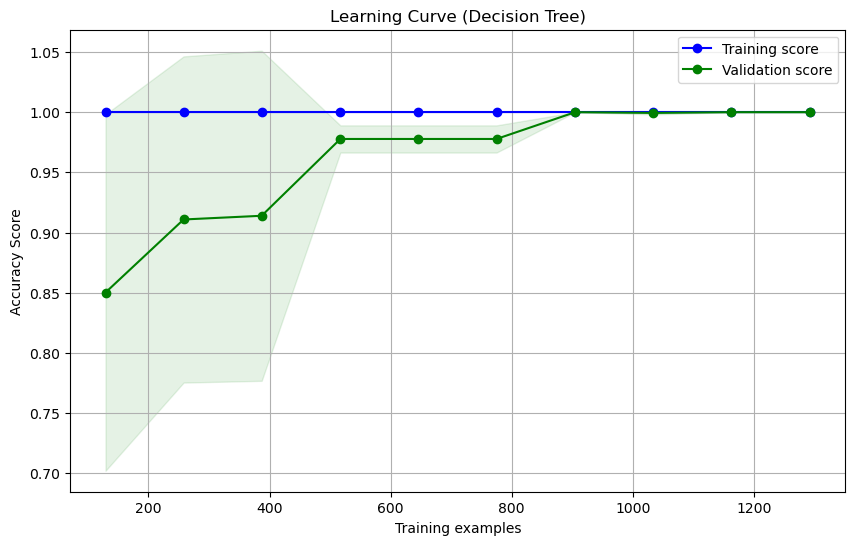


Decision Tree converges at 905 training examples with a validation score of 1.000


In [23]:
#Plot the learning curve for Decision Tree
print("Plotting learning curve for Decision Tree...")
decision_tree_point, decision_tree_score = plot_learning_curve(trained_decision_tree_model, X_resampled, y_resampled, 'Decision Tree')
convergence_points['Decision Tree'] = (decision_tree_point, decision_tree_score)


In [24]:
# Train the Random Forest model
print("Training Random Forest...")
random_forest_model = RandomForestClassifier(random_state=42)
trained_random_forest_model, random_forest_training_time = train_model(random_forest_model, X_train, y_train)
random_forest_metrics, random_forest_classification_rep = evaluate_model(trained_random_forest_model, X_train, y_train, X_test, y_test)
model_metrics['Random Forest'] = random_forest_metrics
print_metrics('Random Forest', random_forest_metrics, random_forest_classification_rep, random_forest_training_time)


Training Random Forest...

Random Forest Training Time: 0.30 seconds
Random Forest Training Accuracy: 1.000
Random Forest Test Accuracy: 0.993
Random Forest Training Precision: 1.000
Random Forest Test Precision: 0.993
Random Forest Training Recall: 1.000
Random Forest Test Recall: 0.993
Random Forest Training F1 Score: 1.000
Random Forest Test F1 Score: 0.992

Classification Report on Test Data:
              precision    recall  f1-score   support

           1       1.00      0.50      0.67         2
           2       0.99      1.00      1.00       136

    accuracy                           0.99       138
   macro avg       1.00      0.75      0.83       138
weighted avg       0.99      0.99      0.99       138



Plotting learning curve for Random Forest...


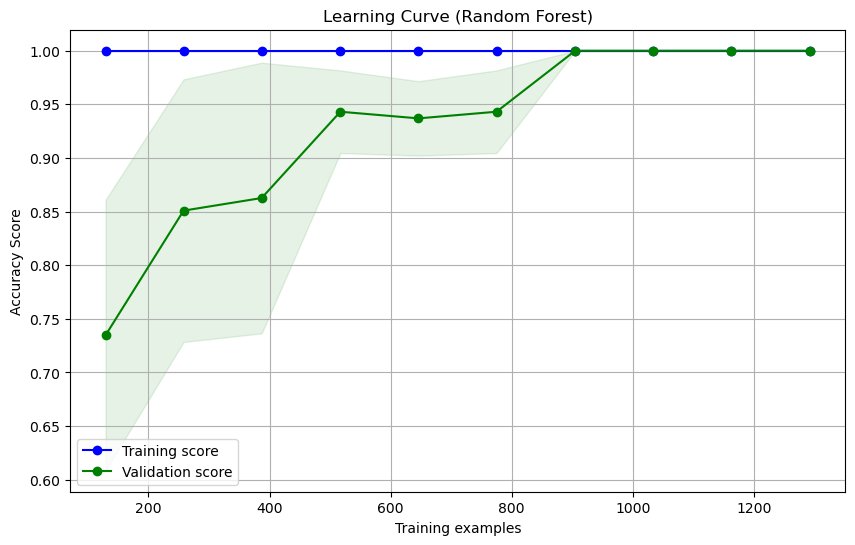


Random Forest converges at 905 training examples with a validation score of 1.000


In [25]:
#Plot the learning curve for Random Forest
print("Plotting learning curve for Random Forest...")
random_forest_point, random_forest_score = plot_learning_curve(trained_random_forest_model, X_resampled, y_resampled, 'Random Forest')
convergence_points['Random Forest'] = (random_forest_point, random_forest_score)


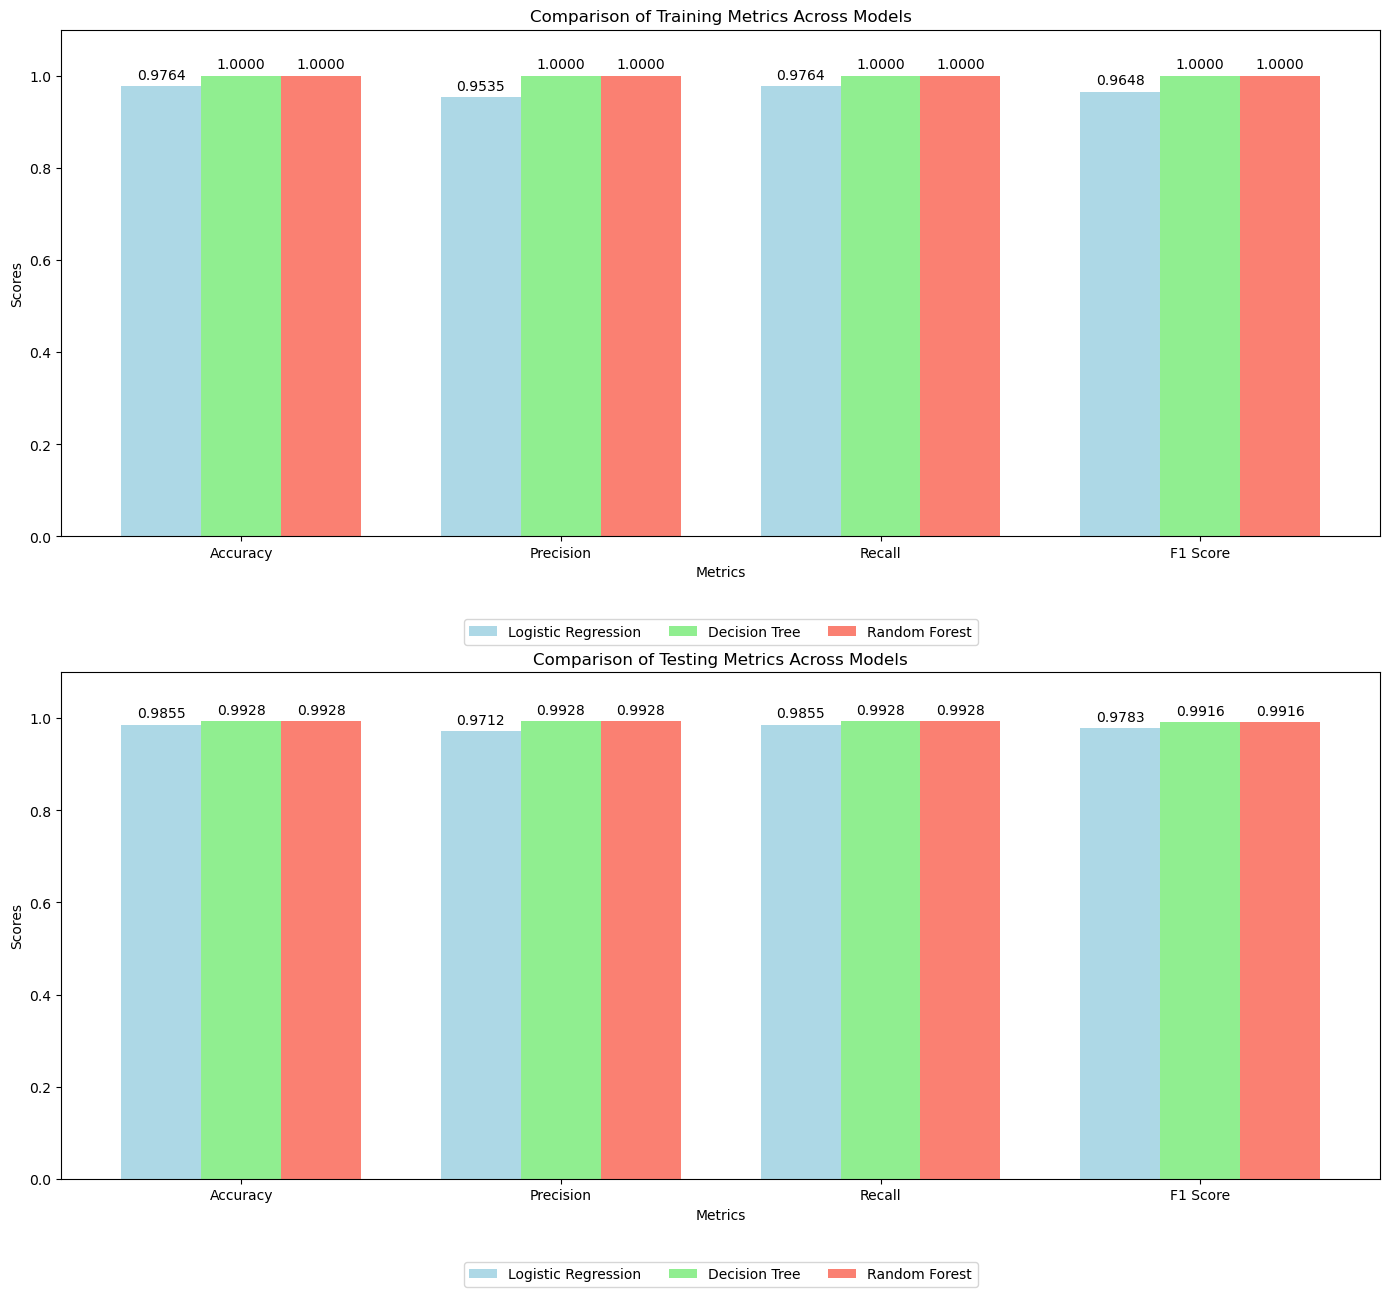

In [26]:
plot_metrics(model_metrics)

In [27]:
# Print convergence points
print("Convergence Points:")
for name, (point, score) in convergence_points.items():
    print(f"{name}: {point} training examples with a score of {score:.3f}")


Convergence Points:
Logistic Regression: 1034 training examples with a score of 1.000
Decision Tree: 905 training examples with a score of 1.000
Random Forest: 905 training examples with a score of 1.000


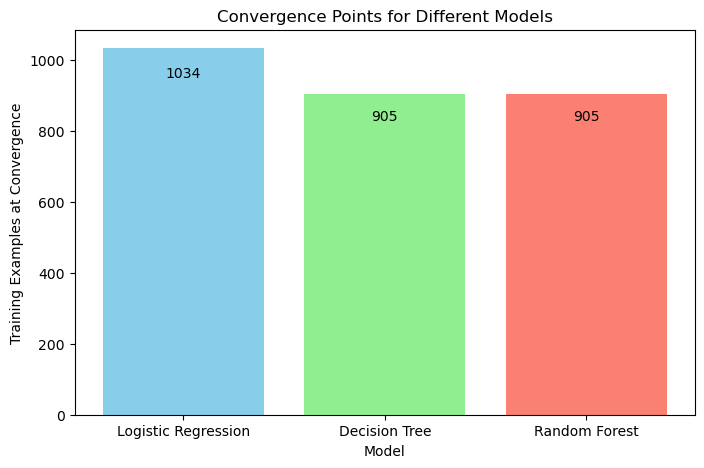

In [28]:
# Plot convergence points
plt.figure(figsize=(8, 5))

# Extract values for plotting
convergence_values = [point for point, _ in convergence_points.values()]  # Extract only the training examples
model_names = list(convergence_points.keys())

# Plot the bar graph
bars = plt.bar(model_names, convergence_values, color=['skyblue', 'lightgreen', 'salmon'])

# Add labels inside the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval - (yval * 0.05), int(yval), ha='center', va='top', color='black')

# Set title and labels
plt.title('Convergence Points for Different Models')
plt.xlabel('Model')
plt.ylabel('Training Examples at Convergence')

# Show the plot
plt.show()


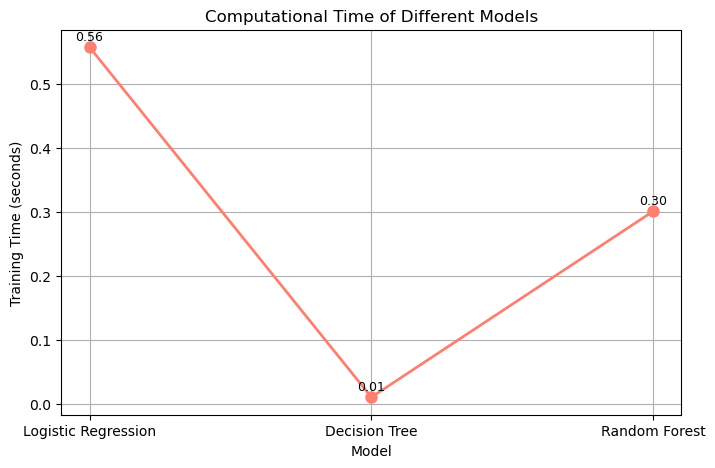

In [31]:
# Dictionary to store the training times of each model
training_times = {
    'Logistic Regression': logistic_training_time,
    'Decision Tree': decision_tree_training_time,
    'Random Forest': random_forest_training_time
}

#Plot computational time
plot_computational_time(training_times)
